In [1]:
# change the current dir so the sys know the .py modules
import os 
os.chdir('/home/jupyter/eye-tracking/python')

In [14]:
import json
import ijson
import base64
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cnn_utils import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
x_train,y_train = create_dataframe()
x_train.head()

,eyeImage,leftEye,rightEye
0,"[[[32, 52, 86], [88, 112, 155], [89, 130, 190]...","[[-0.04106040810056333, -0.2661677002711552], ...","[[0.20645009407383275, -0.25466045058369857], ..."
1,"[[[91, 114, 156], [92, 128, 185], [98, 136, 19...","[[-0.07226874514758119, -0.21267132333102778],...","[[0.1791002113662543, -0.1944043145408635], [0..."
2,"[[[53, 72, 106], [99, 136, 192], [97, 140, 202...","[[-0.05113651627800753, -0.2674861957086695], ...","[[0.21379589102346563, -0.24411637606250924], ..."
3,"[[[53, 65, 96], [105, 134, 180], [97, 142, 203...","[[-0.036367646064764614, -0.23934754171103256]...","[[0.2199010682250715, -0.21605467749028295], [..."
4,"[[[49, 64, 96], [91, 115, 157], [88, 127, 185]...","[[-0.0797204637382114, -0.27350516572426786], ...","[[0.18218327924672018, -0.2482642153566159], [..."


In [4]:
y_train.head()

,y
0,"[-0.45034377387318564, 0.14983534577387492]"
1,"[0.14935064935064934, 0.44950603732162464]"
2,"[-0.45034377387318564, -0.45060373216245886]"
3,"[-0.45034377387318564, 0.44950603732162464]"
4,"[0.44957983193277307, -0.45060373216245886]"


In [5]:
x_train.describe()

,eyeImage,leftEye,rightEye
count,125,125,125
unique,125,125,125
top,"[[[92, 122, 175], [92, 129, 190], [92, 131, 19...","[[-0.06052127160116916, -0.32971692111401407],...","[[0.19516706619808755, -0.322568457116841], [0..."
freq,1,1,1


In [6]:
y_train.describe()

,y
count,125
unique,125
top,"[-0.45034377387318564, 0.14983534577387492]"
freq,1


In [7]:
# access multiple columns
x_train.iloc[:,0:2]

,eyeImage,leftEye
0,"[[[32, 52, 86], [88, 112, 155], [89, 130, 190]...","[[-0.04106040810056333, -0.2661677002711552], ..."
1,"[[[91, 114, 156], [92, 128, 185], [98, 136, 19...","[[-0.07226874514758119, -0.21267132333102778],..."
2,"[[[53, 72, 106], [99, 136, 192], [97, 140, 202...","[[-0.05113651627800753, -0.2674861957086695], ..."
3,"[[[53, 65, 96], [105, 134, 180], [97, 142, 203...","[[-0.036367646064764614, -0.23934754171103256]..."
4,"[[[49, 64, 96], [91, 115, 157], [88, 127, 185]...","[[-0.0797204637382114, -0.27350516572426786], ..."
...,...,...
120,"[[[79, 117, 179], [65, 100, 157], [36, 66, 118...","[[-0.033213769663275605, -0.2290984016174057],..."
121,"[[[82, 120, 178], [67, 102, 157], [40, 71, 121...","[[-0.05008521603051719, -0.22870410061116675],..."
122,"[[[90, 131, 198], [92, 131, 197], [87, 124, 18...","[[-0.04425108086615903, -0.23295326180560938],..."
123,"[[[88, 128, 192], [86, 125, 185], [70, 106, 16...","[[-0.04412834065089355, -0.23486924302635703],..."


In [31]:
binary_labels = create_binary_labels(y_train)
binary_labels.describe()

,y
count,125
unique,2
top,L
freq,66


In [30]:
quaternary_labels = create_quaternary_labels(y_train)
quaternary_labels.describe()

,y
count,125
unique,4
top,LL
freq,36


In [15]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

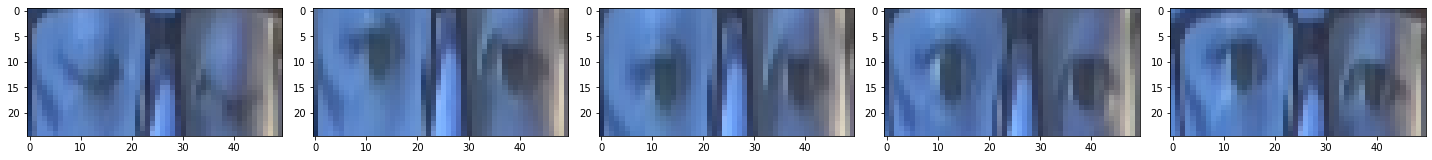

In [29]:
plotImages(x_train["eyeImage"].sample(n = 5))

In [ ]:
def create_train_test():
    